In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
from lsda.mcs import *
from lsda.nn import *
from lsda.score import *
from lsda.utils import *

import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm

### Load data

In [3]:
size = (120, 240)
train_years = np.arange(2000, 2019)
val_years = np.arange(2019, 2021)
test_years = np.arange(2021, 2023)

trainset = ERA5Dataset(years=train_years, size=size, window=1, flatten=True)
validset = ERA5Dataset(years=val_years, size=size, window=1, flatten=True)
trainloader = DataLoader(trainset, batch_size=1, shuffle=False, num_workers=0)
validloader = DataLoader(validset, batch_size=1, shuffle=False, num_workers=0)

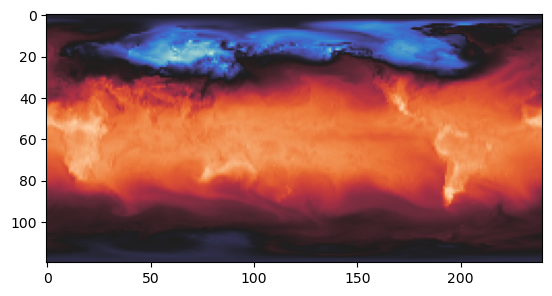

In [4]:
# Plot
x, kwargs = next(iter(trainloader))
plt.imshow(x[0,-1], cmap=sns.cm.icefire)

In [5]:
# Dataset construction
input_size = 10
latent_channels = (9, 8, 7, 6, 5)
kernel_sizes = (5, 5, 5, 5, 5)
window = 1
batch_size = 64

trainset = ERA5Dataset(years=train_years, size=size, window=window, flatten=True)
validset = ERA5Dataset(years=val_years, size=size, window=window, flatten=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=12, persistent_workers=True)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=12, persistent_workers=True)

In [ ]:
# Define hyperparameters
epochs = 64
learning_rate = 2e-4
weight_decay = 1e-3

# Initialize model and optimizer
latent = ConvEncoderDecoder(window * input_size, latent_channels, kernel_sizes).to(device)
optimizer = torch.optim.AdamW(latent.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training loop
all_train_losses = []
all_valid_losses = []

for epoch in tqdm(range(epochs)):
    losses_train = []
    losses_valid = []

    latent.train()

    for batch in trainloader:
        x, kwargs = batch
        x = x.to(device)
    
        z = latent.encoder(x)
        x_ = latent.decoder(z)
        l = (x_ - x).square().mean()
        l.backward()

        optimizer.step()
        optimizer.zero_grad()
        
        losses_train.append(l.detach())

    ## Valid
    latent.eval()

    with torch.no_grad():
        for batch in validloader:
            x, kwargs = batch
            x = x.to(device)
            
            z = latent.encoder(x)
            x_ = latent.decoder(z)
            l = (x_ - x).square().mean()
            
            losses_valid.append(l.detach())

    ## Stats
    all_train_losses.append(torch.stack(losses_train).mean().item())
    all_valid_losses.append(torch.stack(losses_valid).mean().item())
    print(all_valid_losses[-1])

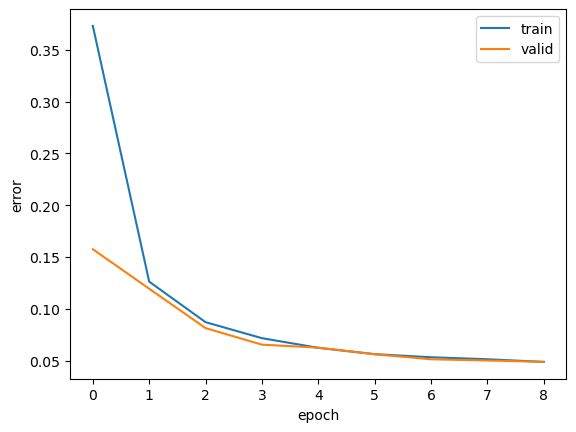

In [7]:
# Plot losses
f, ax = plt.subplots()
ax.plot(np.array(all_train_losses), label='train')
ax.plot(np.array(all_valid_losses), label='valid')
ax.set_xlabel('epoch')
ax.set_ylabel('error')
ax.legend()

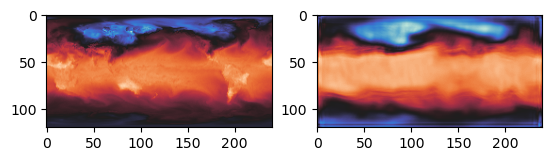

In [39]:
# Qualitative sanity check
test_idx, param_idx = 0, -1

# True
testset = ERA5Dataset(years=test_years, size=size, window=1, flatten=False)
x_true, _ = testset[test_idx]

# Preds
z = latent.encoder(x_true.to(device))
x_ = latent.decoder(z)
x_pred = x_.detach().cpu()


# Plot
f, ax = plt.subplots(1,2)
ax[0].imshow(x_true[0, param_idx], cmap=sns.cm.icefire) # True
ax[1].imshow(x_pred[0, param_idx], cmap=sns.cm.icefire) # Predicted

### Train encoder-decoder

In [6]:
# Dataset construction
all_input_size = 11
input_size = 10
aux_features = all_input_size - input_size
latent_channels = (9, 8, 7, 6, 5)
kernel_sizes = (5, 5, 5, 5, 5)
window = 1
batch_size = 64

trainset = MultimodalDataset(
    ERA5Dataset(years=train_years, size=size, window=window, flatten=True),
    CPCDataset(years=train_years, size=size, window=window, flatten=True)
)

validset = MultimodalDataset(
    ERA5Dataset(years=val_years, size=size, window=window, flatten=True),
    CPCDataset(years=val_years, size=size, window=window, flatten=True)
)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=12, persistent_workers=True)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=12, persistent_workers=True)

In [ ]:
# Define hyperparameters
epochs = 64
learning_rate = 2e-4
weight_decay = 1e-3

# Initialize model and optimizer
latent = ConvEncoderDecoder(window * input_size, latent_channels, kernel_sizes, aux_features).to(device)
optimizer = torch.optim.AdamW(latent.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training loop
all_train_losses = []
all_valid_losses = []

for epoch in tqdm(range(epochs)):
    losses_train = []
    losses_valid = []

    latent.train()

    for batch in trainloader:
        x, kwargs = batch
        x = x.to(device)
    
        z = latent.encoder(x)
        x_ = latent.decoder(z)
        l = (x_ - x[:,:input_size]).square().mean()
        l.backward()

        optimizer.step()
        optimizer.zero_grad()
        
        losses_train.append(l.detach())

    ## Valid
    latent.eval()

    with torch.no_grad():
        for batch in validloader:
            x, kwargs = batch
            x = x.to(device)
            
            z = latent.encoder(x)
            x_ = latent.decoder(z)
            l = (x_ - x[:,:input_size]).square().mean()
            
            losses_valid.append(l.detach())

    ## Stats
    all_train_losses.append(torch.stack(losses_train).mean().item())
    all_valid_losses.append(torch.stack(losses_valid).mean().item())
    print(all_valid_losses[-1])

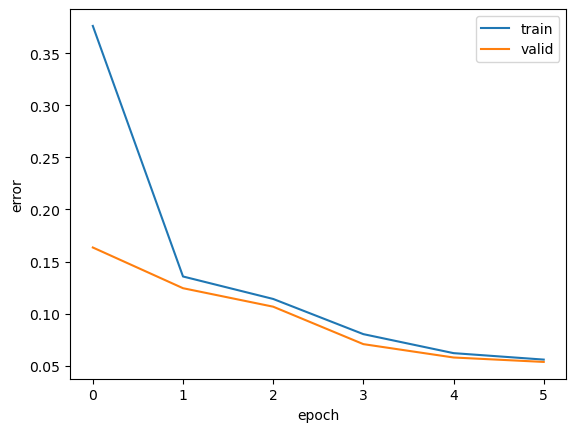

In [8]:
# Plot losses
f, ax = plt.subplots()
ax.plot(np.array(all_train_losses), label='train')
ax.plot(np.array(all_valid_losses), label='valid')
ax.set_xlabel('epoch')
ax.set_ylabel('error')
ax.legend()

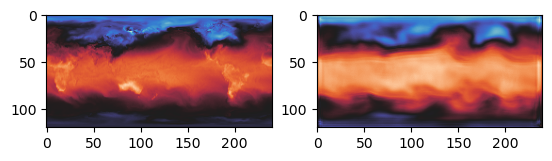

In [9]:
# Qualitative sanity check
test_idx, param_idx = 0, -1

# True
testset = validset = MultimodalDataset(
    ERA5Dataset(years=test_years, size=size, window=window, flatten=False),
    CPCDataset(years=test_years, size=size, window=window, flatten=False)
)

x_true, _ = testset[test_idx]

# Preds
z = latent.encoder(x_true.to(device))
x_ = latent.decoder(z)
x_pred = x_.detach().cpu()


# Plot
f, ax = plt.subplots(1,2)
ax[0].imshow(x_true[0, param_idx - aux_features], cmap=sns.cm.icefire) # True
ax[1].imshow(x_pred[0, param_idx], cmap=sns.cm.icefire) # Predicted

### Train diffusion model

In [63]:
# Latent dataset creation
input_size = 10
batch_size = 64
window = 5
order = window // 2
embedding = 64
hidden_channels = (64, 128, 256)
hidden_blocks = (3, 3, 3)
kernel_size = 3

trainset = ERA5Dataset(years=train_years, size=size, window=window, flatten=True)
validset = ERA5Dataset(years=val_years, size=size, window=window, flatten=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=12, persistent_workers=True)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=12, persistent_workers=True)

In [64]:
# Network
score = MCScoreNet(input_size, order=window // 2)
score.kernel = LocalScoreUNet(
        channels=window * input_size,
        with_forcing=False,
        embedding=embedding,
        hidden_channels=hidden_channels,
        hidden_blocks=hidden_blocks,
        kernel_size=kernel_size,
        activation=torch.nn.SiLU,
        spatial=2,
        padding_mode='circular',
    )

sde = VPSDE(score.kernel, shape=(window * input_size, size[0], size[1])).to(device)


In [65]:
# diffusion
x, kwargs = next(iter(trainloader))
x = x.to(device)
sde.loss(x, **kwargs)

tensor(1.1486, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
# Defining hyperparemeters
epochs = 64
learning_rate = 2e-4
weight_decay = 1e-3
lr = lambda t: 1 - (t / epochs)

optimizer = torch.optim.AdamW(sde.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr)

# Training loop
all_train_losses = []
all_valid_losses = []

for epoch in tqdm(range(epochs)):
    losses_train = []
    losses_valid = []

    sde.train()
    for batch in trainloader:
        x, kwargs = batch
        x = x.to(device)
        
        # compute noise differential loss
        l = sde.loss(x, **kwargs)
        l.backward()

        optimizer.step()
        optimizer.zero_grad()

        losses_train.append(l.detach())

    ## Valid
    sde.eval()

    with torch.no_grad():
        for batch in validloader:
            x, kwargs = batch
            x = x.to(device)
            l = sde.loss(x, **kwargs)
            losses_valid.append(l.detach())

    ## Stats
    all_train_losses.append(torch.stack(losses_train).mean().item())
    all_valid_losses.append(torch.stack(losses_valid).mean().item())
    print(all_valid_losses[-1])

    ## Step
    scheduler.step()

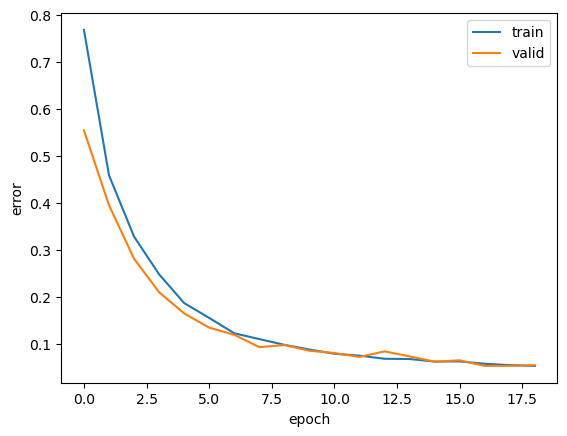

In [13]:
# Plot losses
f, ax = plt.subplots()
ax.plot(np.array(all_train_losses), label='train')
ax.plot(np.array(all_valid_losses), label='valid')
ax.set_xlabel('epoch')
ax.set_ylabel('error')
ax.legend()

### Train latent diffusion model

In [11]:
# Latent dataset creation
hidden_size = latent_channels[-1]
l_size = size
batch_size = 64
window = 5
order = window // 2
embedding = 64
hidden_channels = (32, 64, 128)
hidden_blocks = (3, 3, 3)
kernel_size = 3

trainset = MultimodalDataset(
    ERA5Dataset(years=train_years, size=size, window=window, flatten=False),
    CPCDataset(years=train_years, size=size, window=window, flatten=False)
)

validset = MultimodalDataset(
    ERA5Dataset(years=val_years, size=size, window=window, flatten=False),
    CPCDataset(years=val_years, size=size, window=window, flatten=False)
)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=12, persistent_workers=True)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=12, persistent_workers=True)

In [12]:
# Network
score_latent = MCScoreNet(input_size, order=window // 2)
score_latent.kernel = LocalScoreUNet(
        channels=window * hidden_size,
        with_forcing=False,
        embedding=embedding,
        hidden_channels=hidden_channels,
        hidden_blocks=hidden_blocks,
        kernel_size=kernel_size,
        activation=torch.nn.SiLU,
        spatial=2,
        padding_mode='circular',
    )

lsde = VPSDE(score_latent.kernel, shape=(window * input_size, l_size, l_size)).to(device)


In [13]:
# latent diffusion
x, kwargs = next(iter(trainloader))
x = get_latent(latent, x)
x = x.flatten(1,2)
x = x.to(device)
lsde.loss(x, **kwargs)

tensor(1.1036, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
# Defining hyperparameters
epochs = 64
learning_rate = 2e-4
weight_decay = 1e-3
lr = lambda t: 1 - (t / epochs)

optimizer = torch.optim.AdamW(lsde.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr)

# Training loop
all_train_losses = []
all_valid_losses = []

for epoch in tqdm(range(epochs)):
    losses_train = []
    losses_valid = []

    lsde.train()
    for batch in trainloader:
        x, kwargs = batch
        x = get_latent(latent, x)
        x = x.flatten(1,2)
        x = x.to(device)
        
        # compute noise differential loss
        l = lsde.loss(x, **kwargs)
        l.backward()

        optimizer.step()
        optimizer.zero_grad()

        losses_train.append(l.detach())

    ## Valid
    lsde.eval()

    with torch.no_grad():
        for batch in validloader:
            x, kwargs = batch
            x = get_latent(latent, x)
            x = x.flatten(1,2)
            x = x.to(device)
            
            l = lsde.loss(x, **kwargs)
            
            losses_valid.append(l.detach())

    ## Stats
    all_train_losses.append(torch.stack(losses_train).mean().item())
    all_valid_losses.append(torch.stack(losses_valid).mean().item())
    print(all_valid_losses[-1])

    ## Step
    scheduler.step()

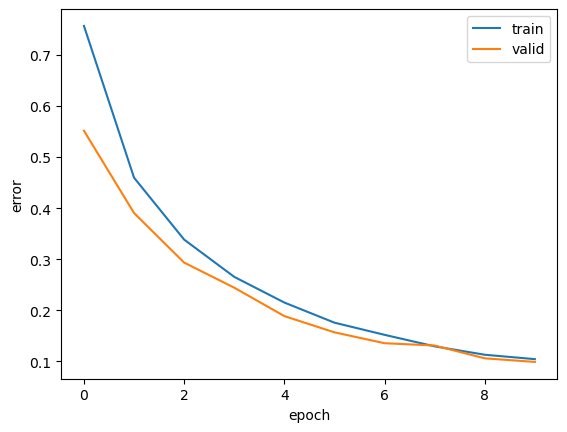

In [18]:
# Plot losses
f, ax = plt.subplots()
ax.plot(np.array(all_train_losses), label='train')
ax.plot(np.array(all_valid_losses), label='valid')
ax.set_xlabel('epoch')
ax.set_ylabel('error')
ax.legend()

### Evaluation

Generate low frequency observations for assimilation (in latent space)

In [19]:
def coarsen(x: Tensor, r: int = 2) -> Tensor:
    *batch, h, w = x.shape

    x = x.reshape(*batch, h // r, r, w // r, r)
    x = x.mean(dim=(-3, -1))

    return x

def upsample(x: Tensor, r: int = 2, mode: str = 'bilinear') -> Tensor:
    *batch, h, w = x.shape

    x = x.reshape(-1, 1, h, w)
    x = torch.nn.functional.pad(x, pad=(1, 1, 1, 1), mode='circular')
    x = torch.nn.functional.interpolate(x, scale_factor=(r, r), mode=mode)
    x = x[..., r:-r, r:-r]
    x = x.reshape(*batch, r * h, r * w)

    return x

In [20]:
# True
testset = MultimodalDataset(
    ERA5Dataset(years=test_years, size=size, window=64, flatten=False),
    CPCDataset(years=test_years, size=size, window=64, flatten=False)
)

test_x, _ = testset[0]

full_x = test_x[:29]
true_x = full_x[:, :input_size]
true_z = latent.encoder(full_x.to(device)).cpu()

w_true = true_x[::4]

In [34]:
# Coarsen
def A(x):
    return coarsen(x[..., ::4, :, :, :], 8)

sigma_sq = 0.1
y_star = torch.normal(A(true_x), sigma_sq)
yz_star = torch.normal(A(true_z), sigma_sq)

w_coarse = y_star
w_coarse = upsample(w_coarse, 2, mode='nearest')

In [35]:
n_corrections = 1
n_steps = 512
tau = 0.5
all_x_sample = []

# # Sampling for diffusion model
# sde_eval = VPSDE(
#     GaussianScore(
#         y_star,
#         A=A,
#         std=sigma_sq,
#         sde=VPSDE(score, shape=()),
#     ),
#     shape=true_x.shape).to(device)

# x = sde_eval.sample(steps=n_steps, corrections=n_corrections, tau=tau)
# x = x[::4]
# all_x_sample.append(x)

# Sampling from latent diffusion model
lsde_eval = VPSDE(
    GaussianScore(
        y=yz_star,
        A=A,
        std=sigma_sq,
        sde=VPSDE(score_latent, shape=()),
    ),
    shape=true_z.shape).to(device)

x = lsde_eval.sample(steps=n_steps, corrections=n_corrections, tau=tau)
x = latent.decoder(x)
x = x[::4]
all_x_sample.append(x)

# Combine all samples
all_x_sample = torch.stack(all_x_sample)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [04:57<00:00,  1.72it/s]


### Plotting: SDA

In [ ]:
param_idx = 0

## 4x coarsening
# Plot true
f, ax = plt.subplots(1, len(w_true), figsize=(16,4))
for N in range(w_true.shape[0]):
    ax[N].imshow(w_true[N,param_idx], cmap=sns.cm.icefire, vmin=-2, vmax=2)
    ax[N].axis('off')
    
    
# Plot coarsen
f, ax = plt.subplots(1, len(w_coarse), figsize=(16,4))
for N in range(w_coarse.shape[0]):
    ax[N].imshow(w_coarse[N,param_idx], cmap=sns.cm.icefire, vmin=-2, vmax=2)
    ax[N].axis('off')
    
# Plot assimilation
for M in range(all_x_sample.shape[0]):
    x_sample = all_x_sample[M]
    x_sample = x_sample.detach().cpu()
    
    f, ax = plt.subplots(1, x_sample.shape[0], figsize=(16,4))
    for N in range(x_sample.shape[0]):
        ax[N].imshow(x_sample[N,param_idx], cmap=sns.cm.icefire, vmin=-2, vmax=2)
        ax[N].axis('off')

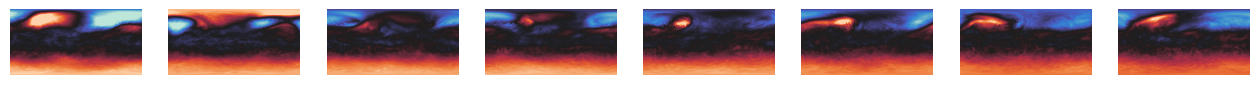

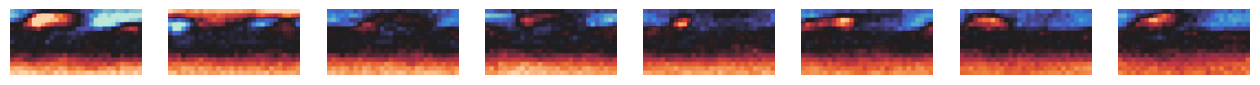

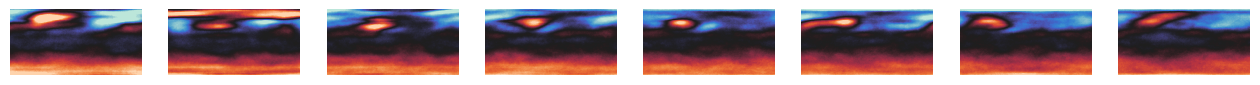

In [39]:
param_idx = 0

## 8x coarsening
# Plot true
f, ax = plt.subplots(1, len(w_true), figsize=(16,4))
for N in range(w_true.shape[0]):
    ax[N].imshow(w_true[N,param_idx], cmap=sns.cm.icefire, vmin=-2, vmax=2)
    ax[N].axis('off')
    
    
# Plot coarsen
f, ax = plt.subplots(1, len(w_coarse), figsize=(16,4))
for N in range(w_coarse.shape[0]):
    ax[N].imshow(w_coarse[N,param_idx], cmap=sns.cm.icefire, vmin=-2, vmax=2)
    ax[N].axis('off')
    
# Plot assimilation
for M in range(all_x_sample.shape[0]):
    x_sample = all_x_sample[M]
    x_sample = x_sample.detach().cpu()
    
    f, ax = plt.subplots(1, x_sample.shape[0], figsize=(16,4))
    for N in range(x_sample.shape[0]):
        ax[N].imshow(x_sample[N,param_idx], cmap=sns.cm.icefire, vmin=-2, vmax=2)
        ax[N].axis('off')

### Plotting: LSDA

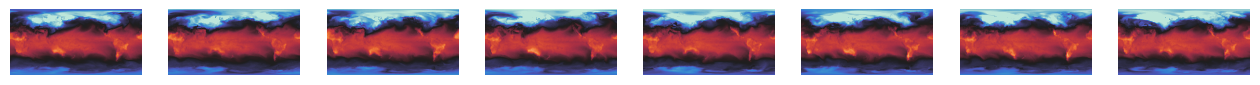

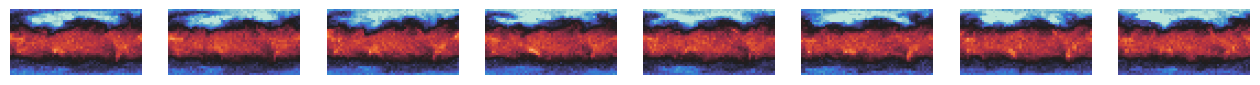

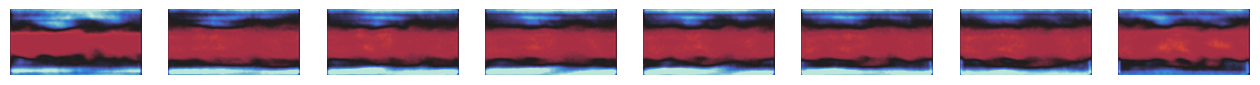

In [33]:
param_idx = -1

## 4x coarsening (latent)
# Plot true
f, ax = plt.subplots(1, len(w_true), figsize=(16,4))
for N in range(w_true.shape[0]):
    ax[N].imshow(w_true[N,param_idx], cmap=sns.cm.icefire, vmin=-2, vmax=2)
    ax[N].axis('off')
    
# Plot coarsen
f, ax = plt.subplots(1, len(w_coarse), figsize=(16,4))
for N in range(w_coarse.shape[0]):
    ax[N].imshow(w_coarse[N,param_idx], cmap=sns.cm.icefire, vmin=-2, vmax=2)
    ax[N].axis('off')
    
# Plot assimilation
for M in range(all_x_sample.shape[0]):
    x_sample = all_x_sample[M]
    x_sample = x_sample.detach().cpu()
    
    f, ax = plt.subplots(1, x_sample.shape[0], figsize=(16,4))
    for N in range(x_sample.shape[0]):
        ax[N].imshow(x_sample[N,param_idx], cmap=sns.cm.icefire, vmin=-2, vmax=2)
        ax[N].axis('off')

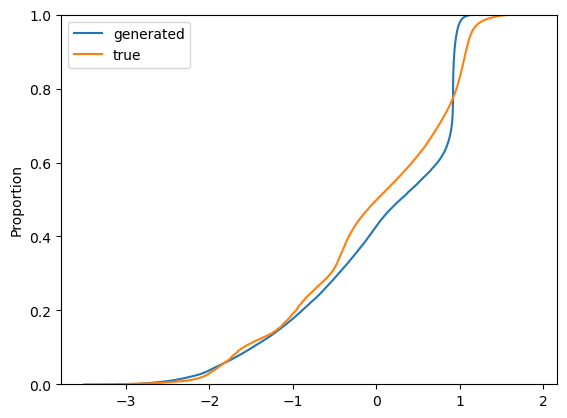

In [24]:
# Plot distribution
f, ax = plt.subplots()

sns.ecdfplot(x_sample[:,param_idx].flatten(), label='generated', ax=ax)
sns.ecdfplot(w_true[:,param_idx].flatten(), label='true', ax=ax)
ax.legend();

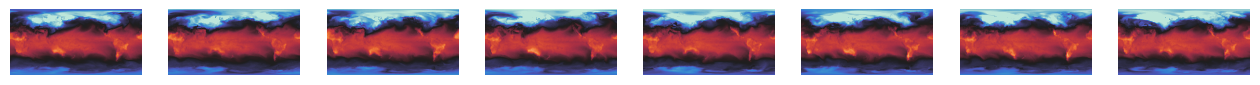

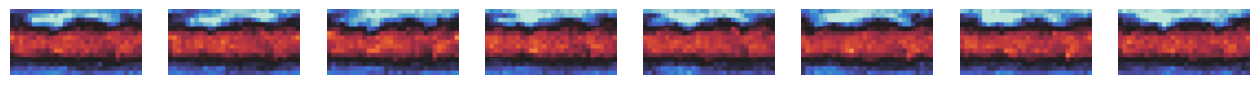

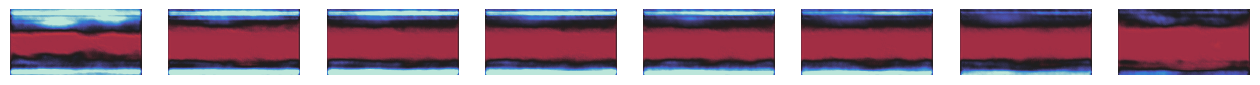

In [36]:
param_idx = -1

## 8x coarsening (latent)
# Plot true
f, ax = plt.subplots(1, len(w_true), figsize=(16,4))
for N in range(w_true.shape[0]):
    ax[N].imshow(w_true[N,param_idx], cmap=sns.cm.icefire, vmin=-2, vmax=2)
    ax[N].axis('off')
    
    
# Plot coarsen
f, ax = plt.subplots(1, len(w_coarse), figsize=(16,4))
for N in range(w_coarse.shape[0]):
    ax[N].imshow(w_coarse[N,param_idx], cmap=sns.cm.icefire, vmin=-2, vmax=2)
    ax[N].axis('off')
    
# Plot assimilation
for M in range(all_x_sample.shape[0]):
    x_sample = all_x_sample[M]
    x_sample = x_sample.detach().cpu()
    
    f, ax = plt.subplots(1, x_sample.shape[0], figsize=(16,4))
    for N in range(x_sample.shape[0]):
        ax[N].imshow(x_sample[N,param_idx], cmap=sns.cm.icefire, vmin=-2, vmax=2)
        ax[N].axis('off')

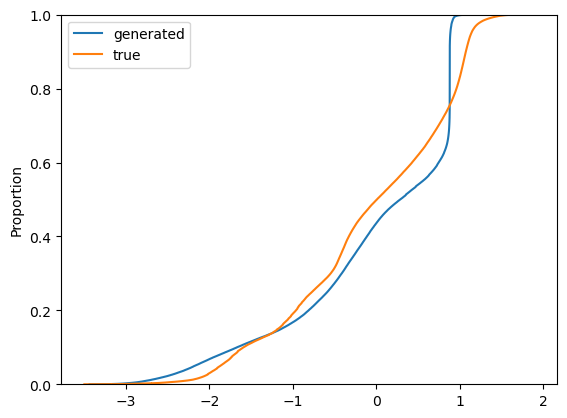

In [37]:
# Plot distribution
f, ax = plt.subplots()

sns.ecdfplot(x_sample[:,param_idx].flatten(), label='generated', ax=ax)
sns.ecdfplot(w_true[:,param_idx].flatten(), label='true', ax=ax)
ax.legend();